In [1]:
import json
import re
import unicodedata
from collections import Counter
from langdetect import detect, DetectorFactory
from googletrans import Translator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Setup
DetectorFactory.seed = 0
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load JSON
with open('amazon_search_results_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nachi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Detect language
raw_reviews = []
language_counts = Counter()
for product in data:
    product_name = product.get("text", "Unknown Product")
    if "Reviewer Details" in product:
        for review in product["Reviewer Details"].values():
            review_text = review.get("review", "")
            try:
                lang = detect(review_text)
            except:
                lang = "undetermined"
            language_counts[lang] += 1
            raw_reviews.append({
                "product": product_name,
                "original_review": review_text,
                "language": lang
            })

# Translate non-English reviews
translator = Translator()
for r in raw_reviews:
    if r["language"] != "en":
        try:
            r["translated_review"] = translator.translate(r["original_review"], dest='en').text
        except:
            r["translated_review"] = r["original_review"]
    else:
        r["translated_review"] = r["original_review"]

print("\n Language Distribution:")
for lang, count in language_counts.items():
    print(f"{lang}: {count}")



 Language Distribution:
it: 159
es: 258
en: 1869
so: 35
et: 5
ro: 29
de: 132
tl: 2
ca: 11
af: 26
fr: 105
hr: 2
id: 6
no: 11
ar: 62
ja: 13
pl: 4
sv: 3
tr: 30
da: 11
nl: 11
pt: 18
fa: 2
fi: 4
undetermined: 7
vi: 2
cs: 4
sk: 2
sl: 2
cy: 5
sq: 1
ko: 1
hu: 1


In [3]:
# Data Preprocessing
def clean_text(text):
    
    # Remove URLs
    text = re.sub(r"http\S+", "", text)     

    # Remove HTML entities
    text = re.sub(r"&[a-z]+;", "", text)

    # Normalize unicode to ASCII
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

In [4]:
# Clean all reviews
for r in raw_reviews:
    r["cleaned_review"] = clean_text(r["translated_review"])

In [5]:
# Top 50 frequent words
stopwords = set(nltk.corpus.stopwords.words('english'))
words = []
for r in raw_reviews:
    tokens = re.findall(r'\b\w+\b', r["cleaned_review"].lower())
    tokens = [word for word in tokens if word not in stopwords]
    words.extend(tokens)
top_50_words = Counter(words).most_common(50)

print("\n Top 50 Most Frequent Words:")
for word, freq in top_50_words:
    print(f"{word}: {freq}")


 Top 50 Most Frequent Words:
skin: 2841
product: 1074
face: 966
use: 784
cleanser: 735
good: 694
dry: 515
using: 512
clean: 452
like: 438
really: 403
well: 397
sensitive: 391
wash: 375
love: 360
great: 350
oil: 308
without: 305
soft: 303
gentle: 302
feeling: 289
leaves: 289
used: 284
one: 282
recommend: 281
also: 280
acne: 280
products: 255
feel: 251
time: 250
feels: 245
oily: 240
makeup: 216
cleansing: 214
little: 210
much: 204
cleaning: 189
foam: 189
first: 187
best: 186
works: 185
make: 182
smell: 176
nice: 171
would: 168
gel: 162
lot: 156
price: 155
excellent: 155
cleaner: 155


In [6]:
# VADER sentiment analysis
sid = SentimentIntensityAnalyzer()
sentiment_results = []
for r in raw_reviews:
    score = sid.polarity_scores(r["cleaned_review"])
    sentiment = "Positive" if score["compound"] >= 0.05 else "Negative" if score["compound"] <= -0.05 else "Neutral"
    sentiment_results.append({
        "product": r["product"],
        "review": r["cleaned_review"],
        "vader_score": score,
        "vader_sentiment": sentiment
    })

print(f"\n Total Reviews Processed: {len(raw_reviews)}")

# Save sentiment results
with open('vader_sentiment_output.json', 'w', encoding='utf-8') as f:
    json.dump(sentiment_results, f, indent=4)

print("\n VADER Sentiment Output saved as 'vader_sentiment_output.json'")


 Total Reviews Processed: 2833

 VADER Sentiment Output saved as 'vader_sentiment_output.json'


In [8]:
import pandas as pd
from collections import defaultdict

# Initialize aggregation structure 
product_scores = defaultdict(lambda: {
    "count": 0,
    "neg": 0.0,
    "neu": 0.0,
    "pos": 0.0,
    "compound": 0.0,
    "positive_reviews": 0,
    "negative_reviews": 0,
    "neutral_reviews": 0
})

# Aggregate scores and sentiment counts
for entry in sentiment_results:
    product = entry["product"]
    score = entry["vader_score"]
    sentiment = entry["vader_sentiment"]

    product_scores[product]["count"] += 1
    product_scores[product]["neg"] += score["neg"]
    product_scores[product]["neu"] += score["neu"]
    product_scores[product]["pos"] += score["pos"]
    product_scores[product]["compound"] += score["compound"]

    if sentiment == "Positive":
        product_scores[product]["positive_reviews"] += 1
    elif sentiment == "Negative":
        product_scores[product]["negative_reviews"] += 1
    else:
        product_scores[product]["neutral_reviews"] += 1

# Compute averages and prepare output
aggregated_scores = []
for product, values in product_scores.items():
    count = values["count"]
    avg_compound = round(values["compound"] / count, 4)

    if avg_compound >= 0.05:
        overall_sentiment = "Positive"
    elif avg_compound <= -0.05:
        overall_sentiment = "Negative"
    else:
        overall_sentiment = "Neutral"

    avg_score = {
        "product": product,
        "avg_neg": round(values["neg"] / count, 4),
        "avg_neu": round(values["neu"] / count, 4),
        "avg_pos": round(values["pos"] / count, 4),
        "avg_compound": avg_compound,
        "review_count": count,
        "positive_reviews": values["positive_reviews"],
        "negative_reviews": values["negative_reviews"],
        "neutral_reviews": values["neutral_reviews"],
        "overall_sentiment": overall_sentiment
    }

    aggregated_scores.append(avg_score)

# Save the scores to CSV file
df = pd.DataFrame(aggregated_scores)
df.to_csv("product_vader_scores.csv", index=False)

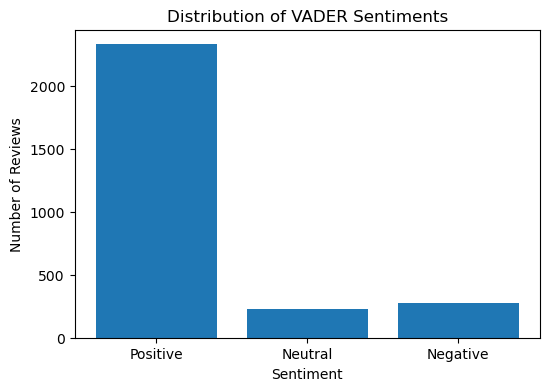

Counter({'Positive': 2328, 'Negative': 277, 'Neutral': 228})


In [38]:
import matplotlib.pyplot as plt

# Load the sentiment results
with open('vader_sentiment_output.json', 'r', encoding='utf-8') as f:
    sentiment_data = json.load(f)

# Count sentiment categories
sentiment_counts = Counter([entry['vader_sentiment'] for entry in sentiment_data])

# Plot
plt.figure(figsize=(6,4))
plt.bar(sentiment_counts.keys(), sentiment_counts.values())
plt.title("Distribution of VADER Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

print(sentiment_counts)


In [34]:
from wordcloud import WordCloud

# Combine positive or negative reviews
positive_text = ' '.join([entry['review'] for entry in sentiment_data if entry['vader_sentiment'] == 'Positive'])
negative_text = ' '.join([entry['review'] for entry in sentiment_data if entry['vader_sentiment'] == 'Negative'])

# Generate WordClouds
WordCloud(width=800, height=400, background_color='white').generate(positive_text).to_image().show(title="Positive Reviews")
WordCloud(width=800, height=400, background_color='white').generate(negative_text).to_image().show(title="Negative Reviews")


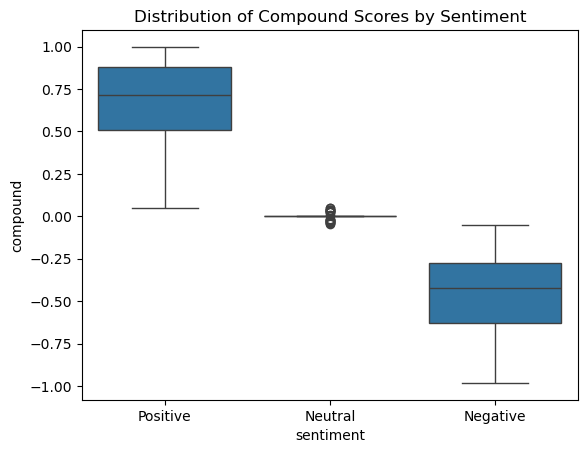

In [35]:
import seaborn as sns

# Convert to DataFrame
df = pd.DataFrame([{
    'compound': entry['vader_score']['compound'],
    'sentiment': entry['vader_sentiment']
} for entry in sentiment_data])

# Plot
sns.boxplot(data=df, x='sentiment', y='compound')
plt.title("Distribution of Compound Scores by Sentiment")
plt.show()
